# Building Models

In [1]:
import gc
import numpy as np
import pandas as pd 
from datetime import datetime,timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [2]:
from pathlib import Path
comp_dir = Path('../input/amazon-product-reviews')

## Import Data

In [3]:
electronics_data=pd.read_csv(comp_dir / "ratings_Electronics (1).csv", dtype={'rating': 'int8'}
                             ,names=['userId', 'productId','rating','timestamp'], index_col=None, header=0)

In [4]:
data_by_date = electronics_data#.copy()
data_by_date.timestamp = pd.to_datetime(electronics_data.timestamp, unit="s")
data_by_date = data_by_date.sort_values(by="timestamp", ascending=False).reset_index(drop=True)
data_by_date["year"]  = data_by_date.timestamp.dt.year.astype("int16")
data_by_date["month"] = data_by_date.timestamp.dt.month.astype("int8")
del electronics_data  ### Free up memory ### 
gc.collect()

0

## Reducing Data

Because many of reviews were before 2010, we only count the recent ones. Even if we have the products that are still available, we can limit the list of product more.

In [5]:
cutoff_year   = 2011  ## Only count Rating after 2011
recent_data   = data_by_date.loc[data_by_date["year"] > cutoff_year]
printmd("**Number of Rating**: {:,}".format(recent_data.shape[0]) )
printmd("**Number of Users**: {:,}".format(len(recent_data.userId.unique()) ) )
printmd("**Number of Products**: {:,}".format(len(recent_data.productId.unique())  ) )
del data_by_date  ### Free up memory ###
gc.collect()

**Number of Rating**: 5,566,858

**Number of Users**: 3,142,438

**Number of Products**: 382,245

21

# 1. Popularity Based Recommendation

We do not count all the products in the past. Only products in period of 30 days are counted, for example.

In [6]:
period = 30

In [7]:
begin_date      = recent_data.timestamp[0] - timedelta(days=period)
data_by_date30  = recent_data.loc[ recent_data.timestamp > begin_date  ]
products_30days = data_by_date30.groupby(["productId"]).agg({"rating":["mean","count"]}).droplevel(axis=1,level=0).reset_index()
top_rated = products_30days.loc[products_30days["count"] > 50].sort_values(by="mean", ascending=False).head(40)

<h3 style="color:red" >List of top products by rating in 30 days</h3>

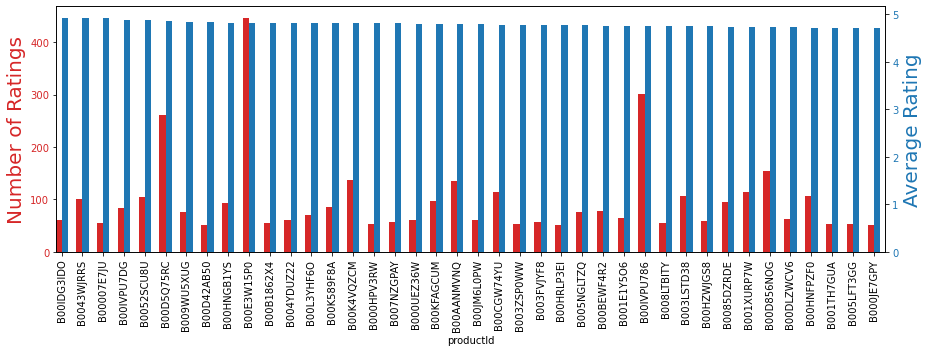

In [8]:
printmd('<h3 style="color:red" >List of top products by rating in {} days</h3>'.format(period))
figsize = (13,5)
fig0, ax1 = plt.subplots(figsize=figsize)
ax2 = ax1.twinx()
top_rated.head(40).plot(kind = "bar",x="productId", y="count", 
                        ax=ax1,align='edge', color="tab:red", width=-0.3, legend=False)
top_rated.head(40).plot(kind = "bar",x="productId", y="mean", 
                        ax=ax2, align='edge',color="tab:blue", width=0.3, legend=False)
############# Style Set up ###############
ax1.set_ylabel('Number of Ratings', color="tab:red", fontsize=20)
ax1.tick_params(axis='y', labelcolor="tab:red")
ax2.set_ylabel('Average Rating', color="tab:blue", fontsize=20)  
ax2.tick_params(axis='y', labelcolor="tab:blue")

plt.tight_layout()
plt.show()

<h3 style="color:red" >List of top products by number of rating </h3>

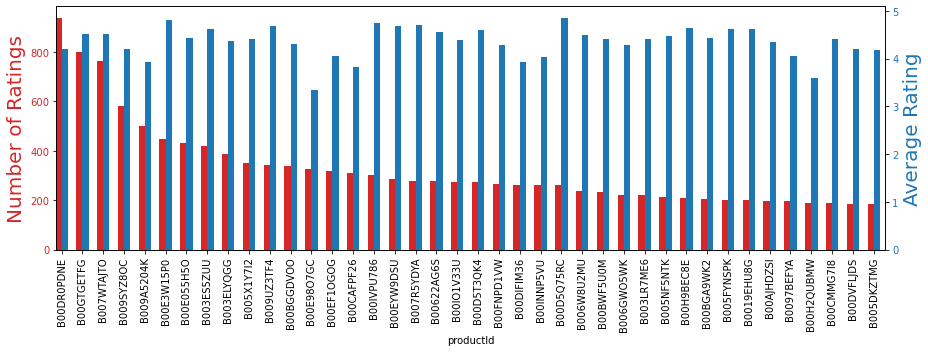

In [9]:
top_rated = products_30days.sort_values(by="count", ascending=False).head(40)

printmd('<h3 style="color:red" >List of top products by number of rating </h3>')
figsize = (13,5)
fig0, ax1 = plt.subplots(figsize=figsize)
ax2 = ax1.twinx()
top_rated.plot(kind = "bar",x="productId", y="count", 
                        ax=ax1,align='edge', color="tab:red", width=-0.3, legend=False)
top_rated.plot(kind = "bar",x="productId", y="mean", 
                        ax=ax2, align='edge',color="tab:blue", width=0.3, legend=False)
############# Style Set up ###############
ax1.set_ylabel('Number of Ratings', color="tab:red", fontsize=20)
ax1.tick_params(axis='y', labelcolor="tab:red")
ax2.set_ylabel('Average Rating', color="tab:blue", fontsize=20)
ax2.tick_params(axis='y', labelcolor="tab:blue")

plt.tight_layout()
plt.show()

# 2. Collaberative filtering

To address some of the limitations of content-based filtering, `collaborative filtering` uses similarities between users and items simultaneously to provide recommendations based on dataset of user/item feedback. This may be either explicit feedback such as a star rating or thumb-up/thumb-down, or implicit feedback such as the number of episodes watched in a TV show.

This allows for serendipitous recommendations; that is, collaborative filtering models can recommend an item to user A based on the interests of a similar user B. Furthermore, the embeddings can be learned automatically, without relying on hand-engineering of features. [Learn more here](https://developers.google.com/machine-learning/recommendation/collaborative/basics)

## Methodology

There are 2 main steps:

a) User-user (or user-based): "people like you, like that" logic
>1. Finding same Rating patterns: Look for other users share the same behaviors. 
>2. Calculating a prediction from those like-minded users found on step 1
>
>pro: number of users is way smaller than the number of items
>con: adding a new user is hard

b) Item-item (or item-based): "if you like this, you might also like that" logic
>1. Building an item-item matrix determining relationships between pairs of items by using the amount of users they have in common.
>2. Infer the tastes of the current user by examining the matrix and matching that user's data
>
>pro: items is way smaller than the number of users, such as large-scale online shops
>con: adding a new item is hard

c) User-item mix: combines both approaches to generate recommendations. The con is still about adding a new user/item.  The simplest ones are based on `matrix factorization` techniques. The idea behind matrix factorization is to represent users and items in a lower dimensional latent space. This factorization is best trained using [SVD](https://medium.com/@m_n_malaeb/singular-value-decomposition-svd-in-recommender-systems-for-non-math-statistics-programming-4a622de653e9), but since this algorithm is very computationally intensive we often prefer alternatives. For medium-scale datasets [ALS](https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1) will give reasonable performances. For large dataset, only the SGD algorithm will be able to scale, but will be very slow. ([Source](https://itnext.io/what-are-the-top-recommendation-engine-algorithms-used-nowadays-646f588ce639))

## Types

1. Memory-based. The approach uses user rating data to compute the similarity between users or items. Typical examples of this approach are neighbourhood-based CF and item-based/user-based top-N recommendations.

2. Model-based. In this approach, models are developed using different data mining, machine learning algorithms to predict users' rating of unrated items. There are many model-based CF algorithms. Bayesian networks, clustering models, latent semantic models such as singular value decomposition, probabilistic latent semantic analysis, multiple multiplicative factor, latent Dirichlet allocation and Markov decision process based models.

3. Deep-Learning. In recent years a number of neural and deep-learning techniques have been proposed. Some generalize traditional Matrix factorization algorithms via a non-linear neural architecture,or leverage new model types like Variational Autoencoders. While deep learning has been applied to many different scenarios: context-aware, sequence-aware, social tagging etc. its real effectiveness when used in a simple collaborative recommendation scenario has been put into question. A systematic analysis of publications applying deep learning or neural methods to the top-k recommendation problem, published in top conferences (SIGIR, KDD, WWW, RecSys), has shown that on average less than 40% of articles are reproducible, with as little as 14% in some conferences.

4. Hybrid. A number of applications combine the memory-based and the model-based CF algorithms. These overcome the limitations of native CF approaches and improve prediction performance. Importantly, they overcome the CF problems such as sparsity and loss of information. However, they have increased complexity and are expensive to implement

## 2.1 Memory-Based K-Nearest-Neighbors Algorithm

K-Nearest-Neighbors is used in classification and prediction by averaging the results of the K nearest data points (i.e. neighbors). It does not create a model, instead it is considered a Memory-Based-Reasoning algorithm where the training data is the “model”. kNN is often used in recommender systems. kNN results are highly dependent on the training data.  kNN is also resource intensive due to many distance calculations.

k-Nearest-Neighbors, or kNN, uses the closest data points to predict the class or value of a new object.  The power of kNN is that it is very local

In [10]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [11]:
reader = Reader(rating_scale=(1, 5))

<h3 style="color:red" > Reducing size is needed </h3>

Because the number of users or items is very large, to quickly demo in a ordinary computer, the size of data is reduced.

###  Item-Item recommedation

In [12]:
cutoff_no_rat = 50    ## Only count products which received more than or equal 50
recent_prod   = recent_data.loc[recent_data.groupby("productId")["rating"].transform('count').ge(cutoff_no_rat)].reset_index(
                    drop=True).drop(["timestamp","year","month"],axis=1)
# Short but much slower:
#new_data = data_by_date.loc[data_by_date["year"] > 2011].groupby("productId").filter(lambda x:x['Rating'].count() >=50)
printmd("**Number of Rating**: {:,}".format(recent_prod.shape[0]) )
printmd("**Number of Users**: {:,}".format(len(recent_prod.userId.unique()) ) )
printmd("**Number of Products**: {:,}".format(len(recent_prod.productId.unique())  ) )

**Number of Rating**: 3,774,595

**Number of Users**: 2,381,833

**Number of Products**: 17,898

In [13]:
#Reading the dataset from Pandas Frame
# It must have three columns, corresponding to the user (raw) ids, the item (raw) ids, and the ratings, in this order.
data = Dataset.load_from_df(recent_prod,reader)
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [14]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
bsl_options = {'method': 'sgd', 'learning_rate': .1,}
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson', 'user_based': False}, bsl_options=bsl_options)
# surprise.similarities.pearson_baseline() : helps to avoid overfitting when only few ratings are available
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [15]:
# run the trained model against the testset
test_pred = algo.test(testset)
#test_pred

In [16]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3198


1.3197980610770461

###  User-User recommendation

#### Reducing size of user

In [17]:
cutoff_no_user= 10    ## Only count users who rated more than or equal 10
recent_users  = recent_prod.loc[recent_prod.groupby("userId")["rating"].transform('count').ge(cutoff_no_user)].reset_index(
                    drop=True)
printmd("**Number of Rating**: {:,}".format(recent_users.shape[0]) )
printmd("**Number of Users**: {:,}".format(len(recent_users.userId.unique()) ) )
printmd("**Number of Products**: {:,}".format(len(recent_users.productId.unique())  ) )

**Number of Rating**: 255,759

**Number of Users**: 16,698

**Number of Products**: 16,981

In [18]:
data_u = Dataset.load_from_df(recent_users,reader)
#Splitting the dataset
trainset_u, testset_u = train_test_split(data_u, test_size=0.3,random_state=10)

In [19]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
bsl_options = {'method': 'sgd',
               'learning_rate': .1,}
algo_u = KNNWithMeans(k=5, sim_options={'name': 'pearson', 'user_based': True}, bsl_options=bsl_options)
algo_u.fit(trainset_u)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [20]:
# run the trained model against the testset
test_pred_u = algo_u.test(testset_u)
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred_u, verbose=True)

User-based Model : Test Set
RMSE: 1.0351


1.0351197462647186

### Conclusion

The accuracy is improved once we remove the items/users with less interactions. E.g., users have many already likes, and products received a lot of ratings would produce better predictions.

In [21]:
### Free up memory ###
del algo, algo_u
gc.collect()

29

# 2.2 Matrix Factorization-based algorithms

In [22]:
from surprise import SVD, NMF

In [23]:
# famous SVD algorithm
MF_CF_SVD = SVD(biased=True, n_epochs=40, lr_all=0.005, reg_all=0.4)
MF_CF_SVD.fit(trainset_u)
# run the trained model against the testset
test_pred_u2 = MF_CF_SVD.test(testset_u)
# get RMSE
print("Matrix Factorization-based Model : Test Set")
accuracy.rmse(test_pred_u2, verbose=True)

Matrix Factorization-based Model : Test Set
RMSE: 0.9754


0.9754451274736983

In [24]:
# biased parameter to False: Probabilistic Matrix Factorization ([salakhutdinov2008a], section 2) 
MF_CF_SVD = SVD(biased=False, n_epochs=40, lr_all=0.005, reg_all=0.4)
MF_CF_SVD.fit(trainset_u)
# run the trained model against the testset
test_pred_u3 = MF_CF_SVD.test(testset_u)
# get RMSE
print("Matrix Factorization-based Model : Test Set")
accuracy.rmse(test_pred_u3, verbose=True)

Matrix Factorization-based Model : Test Set
RMSE: 1.5982


1.5981928897051874

In [25]:
# Non-negative Matrix Factorization
MF_CF_NMF = NMF()
MF_CF_NMF.fit(trainset_u)
# run the trained model against the testset
test_pred_u4 = MF_CF_NMF.test(testset_u)
# get RMSE
print("Matrix Factorization-based Model : Test Set")
accuracy.rmse(test_pred_u4, verbose=True)

Matrix Factorization-based Model : Test Set
RMSE: 1.1324


1.1323605209794116

### GridSearchCV

### Cross Validator

In [26]:
### Free up memory ###
del MF_CF_SVD, MF_CF_NMF
gc.collect()

0

## 2.3 Slope-One algorithms

In [27]:
from surprise import SlopeOne

In [28]:
SlopeOne_CF = SlopeOne()
SlopeOne_CF.fit(trainset_u)
# run the trained model against the testset
test_pred_u5 = SlopeOne_CF.test(testset_u)
# get RMSE
print("Slope-One-based Model : Test Set")
accuracy.rmse(test_pred_u5, verbose=True)

C:\Users\kim_l\AppData\Local\Temp\ipykernel_8372\4171724086.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SlopeOne_CF.fit(trainset_u)


Slope-One-based Model : Test Set
RMSE: 1.1283


1.1283489041102

## 2.4 Model-based collaborative filtering system
These methods are based on machine learning and data mining techniques. The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach. They have large coverage, even when working with large sparse matrices.

In [29]:
# SVD is good at sparse matrix
# Truncated SVD does not centre the data before computing
from sklearn.decomposition import TruncatedSVD

In [30]:
#new_df1=recent_data.head(10000)
new_df1=recent_users
# Utility Matrix: a crosstab matrix
ratings_matrix = new_df1.pivot_table(values='rating', index='productId', columns='userId', fill_value=0, aggfunc="max")
ratings_matrix.head(5)

userId,A0251761JI35FM4C8VK2,A04523701ZTDV9AGO09EC,A0655860XQH1M5Q8JH1M,A08364961O0V6UJTPJB0D,A08871831JFLDQ8W8RJ8Y,A10063PJ5C9WQQ,A100H2245MF6NL,A100NGGXRQF0AQ,A100UD67AHFODS,A100WO06OQR8BQ,...,AZXS6P5QWNMLC,AZXX2IV3T43M2,AZYBZEVISD0YX,AZYJE40XW6MFG,AZZ2DEE2NTIM7,AZZ5ASC403N74,AZZLZUR5X9GYE,AZZTC2OYVNE2Q,AZZX23UGJGKTT,AZZYW4YOE1B6E
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400532655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
printmd("**Most of parts of matrix is spare**")
print("Matrix Dimension  {:,} x {:,}".format(ratings_matrix.shape[0],ratings_matrix.shape[1]))
print("Total number of values  = {:,}".format(ratings_matrix.shape[0]*ratings_matrix.shape[1]))
print("Total number of 0 value = {:,}".format((ratings_matrix==0).sum().sum()))
print("Percentage of 0 value = {:,.2f} %".format(100*((ratings_matrix==0).sum().sum())/(
                                                ratings_matrix.shape[0]*ratings_matrix.shape[1]) ) )

**Most of parts of matrix is spare**

Matrix Dimension  16,981 x 16,698
Total number of values  = 283,548,738
Total number of 0 value = 283,292,979
Percentage of 0 value = 99.91 %


In [32]:
#Decomposing the Matrix
# n_components: set resultant matrix to have 10 dimensions
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(ratings_matrix)
decomposed_matrix.shape

(16981, 10)

In [33]:
#Correlation Matrix
# find out how similar each product to other products on the basis of user tastes
# For each product pair in the matrix, calculate how similar they correlate
correlation_matrix = np.corrcoef(decomposed_matrix)  # Pearson’s R correlation coefficient
correlation_matrix.shape

(16981, 16981)

### Predict an example

In [34]:
# Select a random product
rand_number = 1 # numpy.random.randint(0,100000)
i = ratings_matrix.index[rand_number]
print("Product is: {}".format(i))
# generate list of products that correlate with this one
correlation_list = correlation_matrix[rand_number]
print("Dimension of Correlation List: {}".format(correlation_list.shape))
# Get only high correlationship with the one 
recommend_list = ratings_matrix.index[ (correlation_list > 0.9)].to_list() 
if i in recommend_list: recommend_list.remove(i)  # Removes the item already bought by the customer
print("There are {} products recommended".format(len(recommend_list)))
printmd("**List of recommended products:** <br/>{}".format(recommend_list))

Product is: 1400501466
Dimension of Correlation List: (16981,)
There are 21 products recommended


**List of recommended products:** <br/>['B00005LEOH', 'B000136P8W', 'B000FIH0ZA', 'B000VK5BMQ', 'B000W9DJ1Q', 'B001G4ZA6I', 'B002OOWC3I', 'B003D0ID8U', 'B003MQO96U', 'B004P8K24W', 'B0058SRNZ4', 'B0069OAHUO', 'B006JKARPS', 'B006K551TO', 'B006ZB39QU', 'B00724X77A', 'B007ILK234', 'B0090C7A3O', 'B0092S2TPA', 'B0096WD0KU', 'B00DBDM934']

In [35]:
del correlation_matrix  ### Free up memory ###
del ratings_matrix      ### Free up memory ###
gc.collect()

0

### Wrapping the process

In [36]:
class recommendByTSVD:
    """ Standard scaler of Y with multiple scaler 
    Because the range is to high => log10 (values) to play with magnitude order
    To make it organize, use another Scaler following LOG10.
    Default scale is StandardScaler()
    """
    def __init__(self, model = None):
        if model:
            self.model  = model
        else:
            self.model  = TruncatedSVD(n_components=10)
    def fit(self, data, values='rating', index='productId', columns='userId'):
        self.ratings_matrix     = data.pivot_table(values=values, index=index, columns=columns, fill_value=0)
        self.decomposed_matrix  = self.model.fit_transform(self.ratings_matrix)
        self.correlation_matrix = np.corrcoef(self.decomposed_matrix)  # Pearson’s R correlation coefficient
        
    def predict(self, product, min_corr=0.9):
        productID = list(self.ratings_matrix.index).index(product)
        correlation_list = self.correlation_matrix[productID]
        recommend_list   = self.ratings_matrix.index[ (correlation_list > min_corr)].to_list() 
        if product in recommend_list: recommend_list.remove(product)  # Removes the item already bought by the customer
        return recommend_list

model = recommendByTSVD(TruncatedSVD(n_components=10, random_state=10))
model.fit(recent_users, values='rating', index='productId', columns='userId')
recommend_list = model.predict("1400501466", min_corr=0.95)
printmd("**List of recommended products:** <br/>{}".format(recommend_list))

**List of recommended products:** <br/>['B004DBD4TG', 'B005CG2AX2']

In [37]:
del model
gc.collect()

0

# 3. TensorFlow Recommenders

TensorFlow Recommenders (TFRS) is a library for building recommender system models.

It helps with the full workflow of building a recommender system: data preparation, model formulation, training, evaluation, and deployment. It's built on Keras and aims to have a gentle learning curve while still giving you the flexibility to build complex models. TFRS is open source and available on [Github](https://github.com/tensorflow/recommenders).

TFRS makes it possible to:

* Build and evaluate flexible recommendation retrieval models.
* Freely incorporate item, user, and context information into recommendation models.
* Train multi-task models that jointly optimize multiple recommendation objectives.



In [38]:
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
# Build a model.
class RankingModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        embedding_dimension = 32

        self.user_embeddings = tf.keras.Sequential([
                                    tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_userIds, mask_token=None),
                                        # add addional embedding to account for unknow tokens
                                    tf.keras.layers.Embedding(len(unique_userIds)+1, embedding_dimension)
                                    ])

        self.product_embeddings = tf.keras.Sequential([
                                    tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_productIds, mask_token=None),
                                    # add addional embedding to account for unknow tokens
                                    tf.keras.layers.Embedding(len(unique_productIds)+1, embedding_dimension)
                                    ])
        # Set up a retrieval task and evaluation metrics over the
        # entire dataset of candidates.
        self.ratings = tf.keras.Sequential([
                            tf.keras.layers.Dense(256, activation="relu"),
                            tf.keras.layers.Dense(64,  activation="relu"),
                            tf.keras.layers.Dense(1)
                              ])
    def call(self, userId, productId):
        user_embeddings  = self.user_embeddings (userId)
        product_embeddings = self.product_embeddings(productId)
        return self.ratings(tf.concat([user_embeddings,product_embeddings], axis=1))

# Build a model.
class amazonModel(tfrs.models.Model):

    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
        self.task: tf.keras.layers.Layer   = tfrs.tasks.Ranking(
                                                    loss    =  tf.keras.losses.MeanSquaredError(),
                                                    metrics = [tf.keras.metrics.RootMeanSquaredError()])
            

    def compute_loss(self, features, training=False):
        rating_predictions = self.ranking_model(features["userId"], features["productId"]  )

        return self.task( labels=features["rating"], predictions=rating_predictions)

In [39]:
userIds    = recent_prod.userId.unique()
productIds = recent_prod.productId.unique()
total_ratings= len(recent_prod.index)

In [40]:
ratings = tf.data.Dataset.from_tensor_slices( {"userId":tf.cast( recent_prod.userId.values  ,tf.string),
                                "productId":tf.cast( recent_prod.productId.values,tf.string),
                                "rating":tf.cast( recent_prod.rating.values  ,tf.int8,) } )

In [41]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take( int(total_ratings*0.8) )
test = shuffled.skip(int(total_ratings*0.8)).take(int(total_ratings*0.2))

unique_productIds = productIds
unique_userIds    = userIds

In [42]:
model = amazonModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad( learning_rate=0.1 ))
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()
model.fit(cached_train, epochs=10)

Epoch 1/10
369/369 [==============================] - 20s 48ms/step - root_mean_squared_error: 1.3593 - loss: 1.8465 - regularization_loss: 0.0000e+00 - total_loss: 1.8465
Epoch 2/10
369/369 [==============================] - 2s 5ms/step - root_mean_squared_error: 1.2694 - loss: 1.6107 - regularization_loss: 0.0000e+00 - total_loss: 1.6107
Epoch 3/10
369/369 [==============================] - 2s 5ms/step - root_mean_squared_error: 1.2503 - loss: 1.5627 - regularization_loss: 0.0000e+00 - total_loss: 1.5627
Epoch 4/10
369/369 [==============================] - 2s 5ms/step - root_mean_squared_error: 1.2447 - loss: 1.5487 - regularization_loss: 0.0000e+00 - total_loss: 1.5487
Epoch 5/10
369/369 [==============================] - 2s 5ms/step - root_mean_squared_error: 1.2428 - loss: 1.5441 - regularization_loss: 0.0000e+00 - total_loss: 1.5441
Epoch 6/10
369/369 [==============================] - 2s 5ms/step - root_mean_squared_error: 1.2420 - loss: 1.5421 - regularization_loss: 0.0000e+00

In [43]:
user_rand = userIds[123]
test_rating = {}
for m in test.take(5):
    test_rating[m["productId"].numpy()]=RankingModel()(tf.convert_to_tensor([user_rand]),tf.convert_to_tensor([m["productId"]]))

In [44]:
printmd("**Top 5 recommended products for User {}:** ".format(user_rand))
for m in sorted(test_rating, key=test_rating.get, reverse=True):
    print(m.decode())

**Top 5 recommended products for User A32PYU1S3Y7QFY:** 

B002FFG6JC
B004ABO7QI
B006YW3DI4
B0012YJQWQ
B006ZBWV0K


In [45]:
# Evaluate.
model.evaluate(cached_test, return_dict=True)

185/185 [==============================] - 12s 22ms/step - root_mean_squared_error: 1.3069 - loss: 1.7086 - regularization_loss: 0.0000e+00 - total_loss: 1.70860s - root_mean_squared_error: 1.3031 - loss: 1.6981 - regularization_loss: 0.0000e+00 


{'root_mean_squared_error': 1.3069125413894653,
 'loss': 1.770255446434021,
 'regularization_loss': 0,
 'total_loss': 1.770255446434021}

In [46]:
import sys
def sizeof(va):
    return sizeof_fmt(sys.getsizeof(va ) )
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)
# sizeof_fmt(sys.getsizeof( ) )
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                   recent_data: 837.5 MiB
                   recent_prod: 499.4 MiB
                data_by_date30: 36.4 MiB
                  recent_users: 33.8 MiB
                       new_df1: 33.8 MiB
                       userIds: 18.2 MiB
                unique_userIds: 18.2 MiB
                       testset:  9.1 MiB
                     test_pred:  9.1 MiB
               products_30days:  5.4 MiB
